# ジブリ効果の検証  
金曜ロードショーの放送作品ごとの季節性を検証する。  
以下のブログから過去12年間の放送作品リストを取得。  
https://www.hobiwo.com/entry/kinro

In [1]:
import requests
import re
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties
from bs4 import BeautifulSoup
from BOJScraper import BOJScraper

font_path = '/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

%matplotlib inline

### 1-1 放映作品リストの取得

In [2]:
# htmlデータの取得
html =requests.get('https://www.hobiwo.com/entry/kinro')
soup = BeautifulSoup(html.text, 'lxml')

# 放映日とタイトルを抽出
movie = {}
for ul_tag in soup.find_all("ul"):
    for li in ul_tag.find_all('li', id=None):
        if re.search('[0-9]',li.text)!=None and not('\n' in li.text):
            movie[li.text[:10]]=li.text[10:].replace(' ', '')
            
movie = pd.DataFrame.from_dict(movie, orient='index', columns=['MovieTitle'])
movie.index = pd.to_datetime(movie.index)
movie = movie.sort_index()
movie.tail(20)

,MovieTitle
2018-07-13,ジュラシック・ワールド
2018-07-20,時をかける少女
2018-07-27,バケモノの子
2018-08-03,オデッセイ
2018-08-10,ハウルの動く城
2018-08-17,となりのトトロ
2018-08-24,猫の恩返し
2018-08-31,メアリと魔女の花
2018-09-07,アントマン
2018-09-21,プレデターズ


### 1-2. 為替ヒストリカルデータの取得
日本銀行の統計データサイトより為替レートのヒストリカルデータを取得（期間:1999年1月以降）。  
http://www.stat-search.boj.or.jp/index.html

In [3]:
boj = BOJScraper(currency='USD')
df = boj.getData(1999, 2018)
df = df['1999-01-01':'2019-03-31']
df.tail()

,東京市場 ドル・円 スポット 9時時点,東京市場 ドル・円 スポット 最高値,東京市場 ドル・円 スポット 最安値,東京市場 ドル・円 スポット 17時時点,東京市場 ドル・円 スポット 中心相場,東京市場 ドル・円 スポット出来高,東京市場 ドル・円 スワップ出来高
date,,,,,,,
2018-10-18,112.62,112.73,112.45,112.62,112.51,6073.0,46718.0
2018-10-19,112.20,112.53,112.14,112.44,112.32,6532.0,58497.0
2018-10-22,112.46,112.76,112.36,112.76,112.45,5411.0,57282.0
2018-10-23,112.77,112.84,112.31,112.33,112.75,6415.0,51517.0
2018-10-24,112.45,112.65,112.32,112.51,112.44,7385.0,54063.0


### 1-3. 目的変数の設定
目的変数となる夜間の変化率（東京時間17:00〜翌9:00）の分布を確認

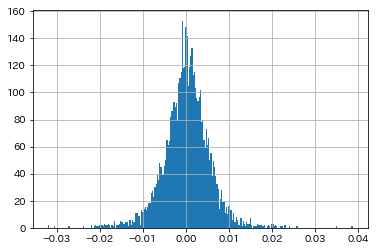

In [4]:
df.columns = ['start', 'high', 'low', 'close', 'TTM', 'volume_spot', 'volume_swap']
df['chg_ON'] = (df['start'].shift(-1) - df['close']) / df['close']
df['chg_ON'].hist(bins=255)

### 1-4. ジブリ効果の検証  
ジブリ効果を検証するため、放映タイトルごとの変化率を集計する（過去3回以上放映された作品のみ）。  

In [5]:
# 為替データと放映タイトルを結合。
movie = movie.join(df['chg_ON'])

# 変化率の絶対値を追加
movie['chg_ON_abs'] = movie['chg_ON'].abs()

# 二値分類用のラベルを追加
movie['label'] = movie['chg_ON'].apply(lambda x: 1 if x>=0 else 0)
movie.label.value_counts()

0    340
1    327
Name: label, dtype: int64

#### 平均変化率

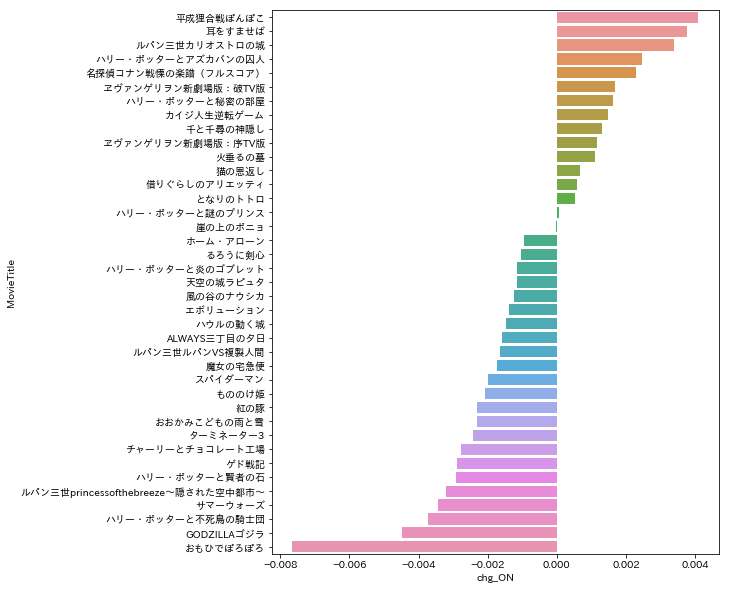

In [6]:
cols = movie.groupby('MovieTitle').mean()[movie.groupby('MovieTitle').count() >2].sort_values(by='chg_ON',ascending=False)[:39].index
titles=movie.loc[movie.MovieTitle.isin(cols)]

plt.figure(figsize=(8, 10))
sns.barplot(x ='chg_ON', y ='MovieTitle', data=titles, order=cols, ci=None)

#### 変化率（絶対値）の平均

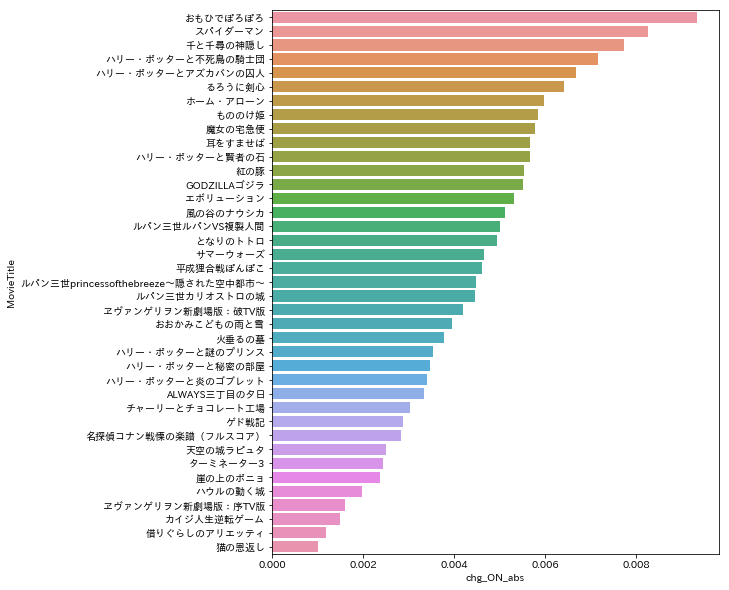

In [7]:
cols = movie.groupby('MovieTitle').mean()[movie.groupby('MovieTitle').count() >2].sort_values(by='chg_ON_abs',ascending=False)[:39].index
titles=movie.loc[movie.MovieTitle.isin(cols)]

plt.figure(figsize=(8, 10))
sns.barplot(x ='chg_ON_abs', y ='MovieTitle', data=titles, order=cols,ci=None)

#### 上昇確率の集計

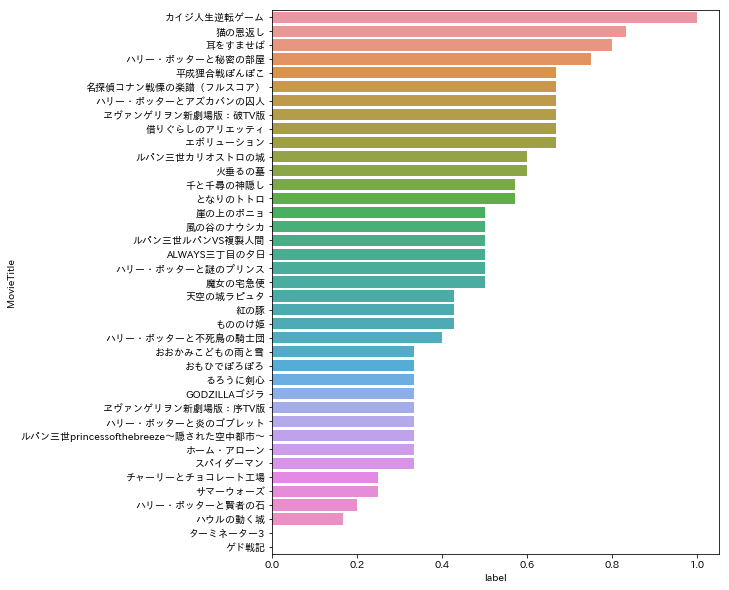

In [8]:
cols = movie.groupby('MovieTitle').mean()[movie.groupby('MovieTitle').count() >2].sort_values(by='label',ascending=False)[:39].index
titles=movie.loc[movie.MovieTitle.isin(cols)]

plt.figure(figsize=(8, 10))
sns.barplot(x ='label', y ='MovieTitle', data=titles, order=cols,ci=None)

In [9]:
movie.groupby('MovieTitle').mean()[movie.groupby('MovieTitle').count() >2].sort_values(by='label',ascending=False)[:39]

,chg_ON,chg_ON_abs,label
MovieTitle,,,
カイジ人生逆転ゲーム,0.001481,0.001481,1.000000
猫の恩返し,0.000682,0.001011,0.833333
耳をすませば,0.003759,0.005669,0.800000
ハリー・ポッターと秘密の部屋,0.001631,0.003474,0.750000
平成狸合戦ぽんぽこ,0.004094,0.004604,0.666667
名探偵コナン戦慄の楽譜（フルスコア）,0.002295,0.002832,0.666667
ハリー・ポッターとアズカバンの囚人,0.002473,0.006680,0.666667
ヱヴァンゲリヲン新劇場版：破TV版,0.001677,0.004186,0.666667
借りぐらしのアリエッティ,0.000587,0.001186,0.666667


In [10]:
movie.to_csv('movie.csv')